ROC panel performance plot created


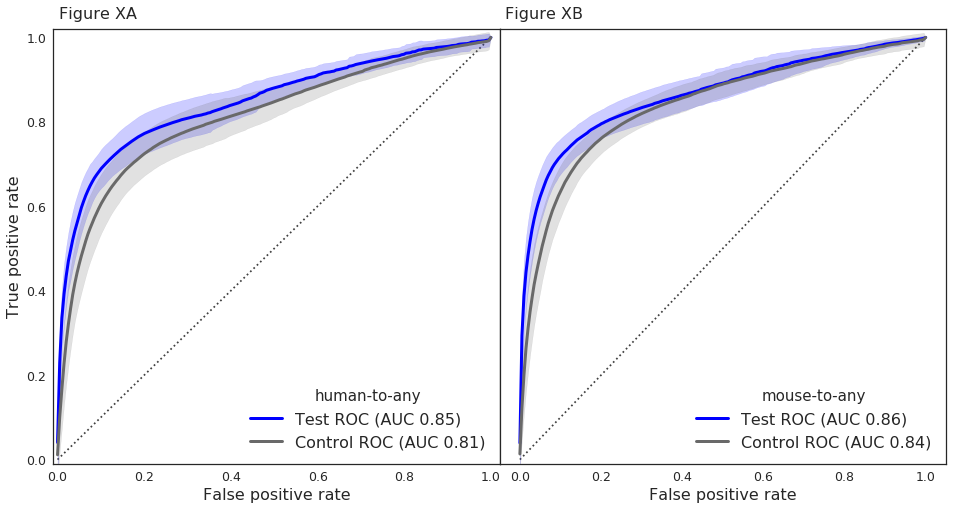

In [57]:
%matplotlib inline

import os as os
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle
from sklearn.metrics import auc, roc_auc_score, \
    average_precision_score, precision_recall_curve, roc_curve

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import numpy as np
import numpy.random as rng
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

from sklearn.metrics import precision_recall_fscore_support as pfm

date = '20180413'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

run_exec_perf_roc_joint = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_status():
    cache_file = os.path.join(cache_dir, '{}_plot_perfcomp_roc-joint.h5'.format(date))
    model = 'can'
    test = 'pos'
    control = 'ctl'
    # return collect_perf, t_interp, control_auc
    if os.path.isfile(cache_file):
        perf_scores = cache_data(cache_file, None, None, None)
    else:
        raw_perf, fpr, control_aucs = collect_roc_curves(stat_file, model, test, control)
        perf_scores = cache_data(cache_file, raw_perf, fpr, control_aucs)

    fig, exart = plot_roc_joint(perf_scores)
    if save_figures:
        outname = 'fig_X_roc_perf.svg'
        outpath = os.path.join(out_folder, 'main', 'raw', outname)
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
        outpath = os.path.join(out_folder, 'main', 'png', outname.replace('.svg', '.png'))
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
        outpath = os.path.join(out_folder, 'main', outname.replace('.svg', '.pdf'))
        fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    return True


def cache_data(cache_file, perfs, fprs, control_aucs):
    
    if os.path.isfile(cache_file):
        perf_scores = {}
        with pd.HDFStore(cache_file, 'r') as hdf:
            for k in hdf.keys():
                if k.startswith('/control_auc') or k.startswith('/fpr'):
                    continue
                _, ref, comp, data = k.split('/')
                dataset = hdf[k]
                perf_scores[(ref, comp, data)] = dataset
            perf_scores['fpr'] = hdf['fpr']
        return perf_scores
    else:
        with pd.HDFStore(cache_file, 'w') as hdf:
            hdf.put('/control_auc', control_aucs, format='table')
            for (ref, comp, data), obj in perfs.items():
                if data == 'auc':
                    hdf.put(os.path.join(ref, comp, data), pd.Series(obj), format='fixed')
                elif data == 'tpr':
                    df = pd.DataFrame(obj, index=np.arange(len(obj)),
                                      columns=np.arange(obj[0].size))
                    hdf.put(os.path.join(ref, comp, data), df, format='fixed')
                else:
                    raise ValueError('Unexpected data type: {}'.format(data))
            hdf.put('/fpr', pd.Series(fprs), format='fixed')
            hdf.flush()
        return cache_data(cache_file, None, None, None)


def plot_roc_joint(perf_data):
    """
    """
    num_cols = 2
    num_rows = 1
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(16, 8),
                           sharex=False, sharey=True)
    extra_artists = []
    
    x_vals_fpr = perf_data['fpr']
    
    human_ax = ax[0]
    human_ax.set_xlim(-0.01, 1.02)
    human_ax.set_ylim(-0.01, 1.02)
    human_ax.set_xlabel('False positive rate', fontsize=16)
    human_ax.set_ylabel('True positive rate', fontsize=16)
    hsa_title = human_ax.set_title('Figure XA', fontsize=16)
    hsa_title.set_position([0.1, 1.01])
    
    hsa_tpr_test = perf_data[('human', 'pos', 'tpr')]
    hsa_tpr_test_mean = hsa_tpr_test.mean(axis=0)
    hsa_tpr_test_std = hsa_tpr_test.std(axis=0)
    
    hsa_tpr_control = perf_data[('human', 'ctl', 'tpr')]
    hsa_tpr_control_mean = hsa_tpr_control.mean(axis=0)
    hsa_tpr_control_std = hsa_tpr_control.std(axis=0)
    
    hsa_test_auc = auc(x_vals_fpr, hsa_tpr_test_mean, reorder=True).round(2)
        
    hsa_control_auc = auc(x_vals_fpr, hsa_tpr_control_mean, reorder=True).round(2)
        
    # plot test perf
    human_ax.plot(x_vals_fpr, hsa_tpr_test_mean, color='blue',
                  ls='solid', lw=3, zorder=3,
                  label='Test ROC (AUC {:.2f})'.format(hsa_test_auc))
    
    human_ax.fill_between(x_vals_fpr,
                          hsa_tpr_test_mean - hsa_tpr_test_std,
                          hsa_tpr_test_mean + hsa_tpr_test_std,
                          alpha=0.2, color='blue', zorder=2)
    
    # plot control perf
    human_ax.plot(x_vals_fpr, hsa_tpr_control_mean, color='dimgrey',
                  ls='solid', lw=3, zorder=3,
                  label='Control ROC (AUC {:.2f})'.format(hsa_control_auc))
    
    human_ax.fill_between(x_vals_fpr,
                          hsa_tpr_control_mean - hsa_tpr_control_std,
                          hsa_tpr_control_mean + hsa_tpr_control_std,
                          alpha=0.2, color='dimgrey', zorder=2)
    
    human_ax.plot((0, 1), (0, 1), ls='dotted', color='black',
                  alpha=0.75, zorder=1)
    human_ax.legend(loc='lower right', ncol=1, title='human-to-any', fontsize=16)
    
    # ============== same for mouse model
    mouse_ax = ax[1]
    mouse_ax.set_xlabel('False positive rate', fontsize=16)
    mmu_title = mouse_ax.set_title('Figure XB', fontsize=16)
    mmu_title.set_position([0.1, 1.01])
        
    mmu_tpr_test = perf_data[('mouse', 'pos', 'tpr')]
    mmu_tpr_test_mean = mmu_tpr_test.mean(axis=0)
    mmu_tpr_test_std = mmu_tpr_test.std(axis=0)
    
    mmu_tpr_control = perf_data[('mouse', 'ctl', 'tpr')]
    mmu_tpr_control_mean = mmu_tpr_control.mean(axis=0)
    mmu_tpr_control_std = mmu_tpr_control.std(axis=0)
    
    mmu_test_auc = auc(x_vals_fpr, mmu_tpr_test_mean, reorder=True).round(2)
        
    mmu_control_auc = auc(x_vals_fpr, mmu_tpr_control_mean, reorder=True).round(2)
        
    # plot test perf
    mouse_ax.plot(x_vals_fpr, mmu_tpr_test_mean, color='blue',
                  ls='solid', lw=3, zorder=3,
                  label='Test ROC (AUC {:.2f})'.format(mmu_test_auc))
    
    mouse_ax.fill_between(x_vals_fpr,
                          mmu_tpr_test_mean - mmu_tpr_test_std,
                          mmu_tpr_test_mean + mmu_tpr_test_std,
                          alpha=0.2, color='blue', zorder=2)
    
    # plot control perf
    mouse_ax.plot(x_vals_fpr, mmu_tpr_control_mean, color='dimgrey',
                  ls='solid', lw=3, zorder=3,
                  label='Control ROC (AUC {:.2f})'.format(mmu_control_auc))
    
    mouse_ax.fill_between(x_vals_fpr,
                          mmu_tpr_control_mean - mmu_tpr_control_std,
                          mmu_tpr_control_mean + mmu_tpr_control_std,
                          alpha=0.2, color='dimgrey', zorder=2)
    
    mouse_ax.plot((0, 1), (0, 1), ls='dotted', color='black',
                  alpha=0.75, zorder=1)
    mouse_ax.legend(loc='lower right', ncol=1, title='mouse-to-any', fontsize=16)
    
    plt.subplots_adjust(wspace=0.)
    
    return fig, extra_artists


def read_references(species, lca):
    """
    """
    lca_dist = dict()
    with open(lca_times_file, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            if r['timetree-org'] in ['human', 'mouse']:
                src = r['timetree-org']
                for k, v in r.items():
                    if k.startswith('time'):
                        continue
                    lca_dist[(src, k)] = int(v)
            else:
                break
    
    spec_ann = dict()
    with open(species, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            spec_ann[r['common_name']] = r

    return spec_ann, lca_dist
  

-


if run_exec_perf_roc_joint:
    execd = exec_status()
    print('ROC panel performance plot created')   
